In [1]:
from addit.dit import rundit
import jax.numpy as jnp
import numpy as np
from addit.ncf import inc3D

In [2]:
np.random.seed(0)

In [3]:
N=10000
Ng_nu=20000
Ng_beta=10
Ng_gammaL=10

nus=np.linspace(2050.0,2250.0,Ng_nu) #nu grid
beta_grid=np.logspace(-2,4,Ng_beta) #beta grid
gammaL_grid=np.logspace(-2,4,Ng_gammaL)#gammaL grid
S=np.logspace(0.0,2.0,N)
S[0:10]=1000.0

In [4]:
nu_lines=np.random.rand(N)*(nus[-1]-nus[0]-50.0)+nus[0]+25.0
beta=np.random.rand(N)*1.0
gammaL=np.random.rand(N)*1.0

In [5]:
F0=rundit(S,nu_lines,beta,gammaL,nus,beta_grid,gammaL_grid)

In [6]:
import matplotlib.pyplot as plt

In [7]:
from exojax.spec import xsection
xsv=xsection(nus,nu_lines,beta,gammaL,S)

100%|██████████| 51/51 [00:01<00:00,  5.07it/s]


In [8]:
nus[1]-nus[0]

0.010000500024943904

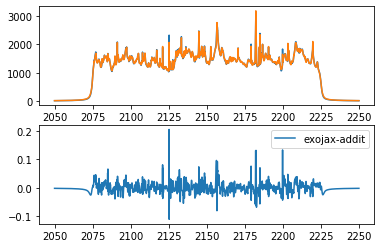

In [9]:
fig=plt.figure()
fig.add_subplot(211)
plt.plot(nus,xsv,label="exojax")
plt.plot(nus,F0,label="addit")
fig.add_subplot(212)
plt.plot(nus,(xsv-F0)/np.median(xsv),label="exojax-addit")
plt.legend()
#plt.xlim(2020,2030)

(2120, 2130)

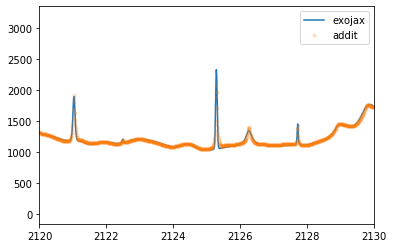

In [12]:
fig=plt.figure()
plt.plot(nus,xsv,label="exojax")
plt.plot(nus,F0,".",alpha=0.2,label="addit")
plt.legend()
plt.xlim(2120,2130)